In [ ]:
# deep learning
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

# other libraries 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## ***CLASSIFICATION WITH EXTRACTED FEATURES***

We want to classify the presence of malignant/benign cancer given a focused image. After the **extraction of features** obtained by cutting the neural network, some _classifiers are trained_ to understand when a cancer is malignant or benign. 

### Import

In [ ]:
path = '/content/gdrive/MyDrive/DSIM/Focus/'
# dataset creation
x = []
y = []


for dir0 in os.listdir(path):  
  print(dir0,"\n\n") ## MalignFocus / BeningFocus
  if dir0=='MalignFocus':
    classes=0
  else:
     classes=1
  print(classes)
  
  for dir1 in os.listdir(path+dir0):
    print(path+dir0+"/"+dir1,"\n") ## CC/MLO

    for dir2 in os.listdir(path+dir0+"/"+dir1):
        img = image.load_img(path+dir0+"/"+dir1+"/"+dir2, target_size=(224, 224))
        img = image.img_to_array(img)
        x.append(img)
        y.append(classes)

  
  # malign classes = 0 | benign classes = 1

MalignFocus 


0
/content/gdrive/MyDrive/DSIM/Focus/MalignFocus/MLO 

/content/gdrive/MyDrive/DSIM/Focus/MalignFocus/CC 

BenignFocus 


1
/content/gdrive/MyDrive/DSIM/Focus/BenignFocus/MLO 

/content/gdrive/MyDrive/DSIM/Focus/BenignFocus/CC 



### Help Functions

In [ ]:
def plot_confusion_matrix(y_test,y_pred, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(classification_report(y_test, y_pred, target_names = classes))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

### Feature Extraction

In this section the aim is to extract features from the VGG16. In particular we have cut the model at different blocks, selecting then the best for our purpose. 

In order to have the best performance, we have tried different cuts: 
1. `block3_pool`
2. `block4_pool`
3. `block5_pool`

We have noticed that classifiers perfomance decreased by selecting deeper layer. So at the end we have chosen the **third convolutional block**. Looking at the *vgg16 model summary()*, this block is located at the beginning of the network. In this way we have selected a more general layer capable to capture basic forms, that could be useful to extract meaningful pattern on our images. 

Once features are extracted we have tried different **classifiers** such as:
- Naive Bayes
- Logistic Regression
- Stochastic Gradient Descent Classifier



**N.B.**

Is it worth to notice that with positive class we denote the Benign Cancer, while with negative class we denote the Malign Cancer. 

In [ ]:
#--  Download of the Network without Fully connected layers.
base_model = VGG16( weights = 'imagenet', include_top = False)

In [ ]:
# # # # # # # # # # # # # #
x = np.array(x)           #
x = preprocess_input(x)   #
y = np.array(y)           # 
# # # # # # # # # # # # # #

In [ ]:
 # feature extraction
first_model_pool3 = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)
block3_pool = first_model_pool3.predict(x)

In [ ]:
###  Block 3:
x_train_b3, x_test_b3, y_train_b3, y_test_b3 = train_test_split( block3_pool,
                                                                 y,
                                                                 test_size=0.2,
                                                                 shuffle=True)

x_train_b3 = np.array([img.flatten() for img in x_train_b3])
x_test_b3 = np.array([img.flatten() for img in x_test_b3])

In [ ]:
labels = ["maligno","benigno"]

### Naive Bayes

In [ ]:
## Cross validation blocco 3 CC
#param_grid = {'alpha': [0, 1,2,5,7]}
#clf = GridSearchCV(MultinomialNB(fit_prior=True), param_grid, cv=3)
#clf = clf.fit(x_train_b3,y_train_b3)
mul_class_b3 = MultinomialNB(alpha=2,fit_prior=True).fit(x_train_b3,y_train_b3)
y_pred_b3 = mul_class_b3.predict(x_test_b3)

              precision    recall  f1-score   support

     maligno       0.65      0.66      0.65       251
     benigno       0.66      0.65      0.66       255

    accuracy                           0.66       506
   macro avg       0.66      0.66      0.66       506
weighted avg       0.66      0.66      0.66       506

Confusion matrix, without normalization
[[165  86]
 [ 88 167]]


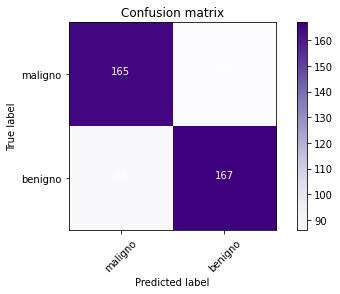

In [ ]:
plot_confusion_matrix(y_test=y_test_b3,y_pred=y_pred_b3,cm=confusion_matrix(y_pred=y_pred_b3,y_true=y_test_b3),classes=labels)

**Comments:**

Is it difficult to see but the FN = 88, while the FP = 86. In any case there is a little difference between them. The value we care the most are obviously the FP. And the reason why it is important lies on the fact that with a false positive we are saying that a person has a benign cancer but in reality it has a malignant one.  

### Logistic Regression

In [ ]:
logistic_reg_b3 = LogisticRegression().fit(x_train_b3,y_train_b3)
log_pred_b3 = logistic_reg_b3.predict(x_test_b3)

              precision    recall  f1-score   support

     maligno       0.66      0.60      0.63       247
     benigno       0.65      0.71      0.68       259

    accuracy                           0.66       506
   macro avg       0.66      0.65      0.65       506
weighted avg       0.66      0.66      0.65       506

Confusion matrix, without normalization
[[148  99]
 [ 75 184]]


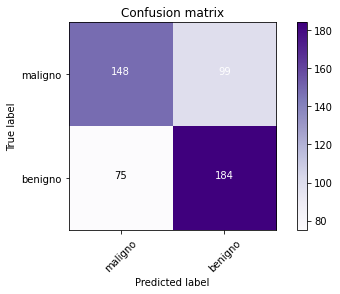

In [ ]:
plot_confusion_matrix(y_test=y_test_b3,y_pred=log_pred_b3,cm=confusion_matrix(y_pred=log_pred_b3,y_true=y_test_b3),classes=labels)

**Comments:**

It has the same accuracy of the NaiveBayes but a higher number of FP. Indeed the Naive Bayes is the best so far. 

### SGDClassifier

In [ ]:
sgd = SGDClassifier()
sgd = sgd.fit(x_train_b3,y_train_b3)
sgd_pred = sgd.predict(x_test_b3)

              precision    recall  f1-score   support

     maligno       0.68      0.67      0.67       253
     benigno       0.67      0.68      0.68       253

    accuracy                           0.68       506
   macro avg       0.68      0.68      0.68       506
weighted avg       0.68      0.68      0.68       506

Confusion matrix, without normalization
[[170  83]
 [ 81 172]]


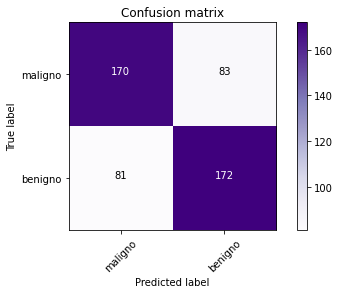

In [ ]:
plot_confusion_matrix(y_test=y_test_b3,y_pred=sgd_pred,cm=confusion_matrix(y_pred=sgd_pred,y_true=y_test_b3),classes=labels)

**Comments**

It reachs the highest accuracy and the lowest number of FP. So with respect to what has been stated before, it is the best classifier. 

### Results

In term of accuracy the best classifier was the `SGD Classifier: 0.68`. Followed by the:
2. `Naive Bayes: 0.66`
3. `Logistic Regression: 0.66`

As stated early, we prefer the Naive Bayes since it has a lower FP value than Logistic Regression. 